In [ ]:
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path as pt
import torch
import torchaudio
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio import transforms
from torchvision.transforms import v2
# from Moduls.MosreDataset import MosreDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.nn.parallel import DataParallel
from collections import Counter

DIVICE = torch.device("cuda")

MAIN = pt(os.getcwd())
DATASET_PATCH = MAIN / 'morse_dataset'
AUDIO_FILES = DATASET_PATCH / 'morse_dataset'

# Поятоянные значения выявленные в процессе анализа
MORSEALP = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"
MAX_TIME = 48
SAMPLE_RATE = 8000
N_MELS = 64
N_FFT = 512
HOP_LENGTH = 160
TOP_DB = 80
FREQ_MASK = 15
TIME_MASK = 20

# Гиперпараметы обучения
SEED = 42
BATCH_SIZE = 64
EPOCHS = 60
LEARNING_RATE = 0.0002 #2e-4
WEIGHT_DECAY = 0.00001
# int_to_alph = dict(enumerate(MORSEALP))
# alph_to_int = {char:enum for enum, char in int_to_alph.items()}

#===== Import data =====
train_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'train.csv'))
test_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'test.csv'))
sample_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'sample_submission.csv'))

all_chars = Counter("".join(train_data['message']))
BLANK_CHAR = "_"
vocab_list = sorted(all_chars.keys()) + [BLANK_CHAR]
num_classes = len(vocab_list)
char_to_int = {char: i for i, char in enumerate(vocab_list)}
int_to_char = {i: char for i, char in enumerate(vocab_list)}
BLANK_IDX = char_to_int[BLANK_CHAR]


import audiomentations as am

augment = am.Compose([
    am.AddGaussianNoise(p=0.3),
    am.TimeStretch(p=0.3),
    am.PitchShift(p=0.3),
    am.LowPassFilter(p=0.3),
    am.ClippingDistortion(p=0.2)
])
class MosreDataset(Dataset):
    """
    Класс для обработки 
    """
    def __init__(self, df, data_patch,char_to_int, train=True, transforms=None, prev_chars = 1):
        self.df = df
        self.is_train = train

        self.data_path = data_patch
        self.audio_paths = self.data_path / 'morse_dataset'

        self.transforms = transforms

        self.char_to_int = char_to_int
        self.prev_chars = prev_chars

        if self.is_train:
            self.messeges = self.df.message.values

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #Получение аугментрованых спектрограмм
        try:
            audio_file = self.audio_paths / self.df.id.values[index]
            waveform, sample_rate = torchaudio.load(audio_file)
            waveform = waveform
            # аунментация аудио
            # waveform_np = waveform.numpy().squeeze(0)
            # augmented = augment(samples=waveform_np, sample_rate=8000)
            # waveform = torch.from_numpy(augmented).unsqueeze(0)

            augmented_spectrogram = self.transforms(waveform)

            if self.is_train:
                message = self.messeges[index]
                #Получение списка индексов секта - как требует CTC los
                '''
                При обработке dataloader labels будут выравниваться по макс длине для выравнивания батча
                Т.е. будет padding 0. что в будующем будет пустым значением для ctc loss
                '''
                target = torch.tensor([self.char_to_int[char] for char in message], dtype=torch.long); 
                target_len = torch.tensor(len(target), dtype=torch.long)
                return augmented_spectrogram, target, target_len, message
            else:
                return augmented_spectrogram, None, None, None
        except Exception as ex:
            print(str(ex))
    
FIRST_FE_COUNT = 16
SECOND_FE_COUNT = 32
THIRD_FE_COUNT = 32
QAD_FE_COUNT = 32
PADDING = 'same'
MAXPOOL_KERNEL = 2
KERTNEL_SIZE = 3
NERON_COUNT = 128
GRU_HIDEN = 512
DROPOUT = 0.4
# Start with 4 transforms
class MorseNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=FIRST_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(FIRST_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((1, 2), (1, 2)), # [batch, FIRST_FE_COUNT = 16, 64, 960]

            nn.Conv2d(in_channels=FIRST_FE_COUNT, 
                      out_channels=SECOND_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(SECOND_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)), # [batch, SECOND_FE_COUNT = 32, 32, 480]

            nn.Conv2d(in_channels=SECOND_FE_COUNT, 
                      out_channels=THIRD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(THIRD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 2), (2, 2)), # [batch, THIRD_FE_COUNT = 32, 16, 240]

            nn.Conv2d(in_channels=THIRD_FE_COUNT, 
                      out_channels=QAD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(QAD_FE_COUNT),
            nn.GELU(),
            nn.MaxPool2d((2, 1), (2, 1)) # [batch=32, QAD_FE_COUNT = 32, 8, 80](что юы сохраниить большще признаков по горизонтали)
        )
        with torch.no_grad(): 
            dummy_input = torch.randn(1, 1, N_MELS, 356); 
            cnn_out = self.net_conv(dummy_input); 
            self.cnn_output_features = cnn_out.shape[1] * cnn_out.shape[2]

        print(f"CNN размерность выхода: {cnn_out.shape}"); 
        print(f"CNN число фичей: {self.cnn_output_features}")
        
        # Добавлен лоейный слой и функция активации. что бы созратить разменрость
        self.layer1 = nn.Linear(self.cnn_output_features, N_MELS*2); 
        self.gelu = nn.GELU()
        self.rnn = nn.GRU(
                input_size=N_MELS*2,
                hidden_size=GRU_HIDEN,
                num_layers=3,
                bidirectional=True,
                dropout=DROPOUT,
                batch_first=True 
            )
        
        self.embed_dim = GRU_HIDEN * 2
        # self.attention = nn.Sequential(
        #     nn.Linear(self.embed_dim, 128),
        #     nn.Tanh(),
        #     nn.Linear(128, 1),
        #     nn.Softmax(dim=1) # по временной оси
        # )
        self.attention = nn.MultiheadAttention(self.embed_dim, 
                                               num_heads=8, 
                                               dropout=DROPOUT, 
                                               batch_first=True)
        self.layer_norm = nn.LayerNorm(self.embed_dim)      
        self.dropout = nn.Dropout(DROPOUT)   
        self.layer2 = nn.Linear(self.embed_dim, num_classes)       
     

    def forward(self, x):
        x = self.net_conv(x)

        batch, channels, reduced_mels, reduced_time = x.shape
        x = x.permute(0, 3, 1, 2)  # [batch, time, channels, mels]

        # # В частности, каждый вектор признаков в последовательности признаков генерируется 
        # # слева направо на картах признаков. Это означает, что i-й вектор признаков представляет 
        # # собой объединение столбцов всех карт. 
        # # Таким образом, форма тензора может быть изменена, например, на (размер_пакета, 80, 256)
        
        x = x.reshape(batch, reduced_time, -1)  # to GRU [batch=64, seq_len=100, features/hiden_dim=256]
        x = self.layer1(x)
        x = self.gelu(x)

        self.rnn.flatten_parameters()

        x = self.rnn(x) # [batch=32, seq_len=89, features/hiden_dim=256 * 4] 4-тк 2 слоя RNN
        x, _ = x # берем информацию со всез состояний
        
        # #attention
        attn, _ = self.attention(x,x,x)
        x = x + attn
        # attn_weights = self.attention(x)
        # x = x * attn_weights
        x = self.layer_norm(x)
        attn = self.dropout(x)
        x = self.layer2(x) # logits - [batch, sequence, num_classes] 
        x = nn.functional.log_softmax(x.permute(1,0,2), dim=2) # pertime так как CTC loss требует на взод (sequence/T,batch/N,num_classes/C)
        '''
        по одному прогнозу для каждого из признаков в последовательности, 
        в итоге получается 89 прогнозов символов для каждой секунды звука.
        '''
        return x
    

train_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    transforms.FrequencyMasking(freq_mask_param=FREQ_MASK),
    transforms.TimeMasking(time_mask_param=TIME_MASK),
    # v2.RandomCrop((N_MELS, 1920)) # Обрезает последний кадр спектрограммы, в идеале надобы считать а не прописывать число
    ) # заметка - Данные трансформации не создают довых обучаемых параметров. Но есть и те что создают. В будущем это стоит учитывать

valid_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    # v2.CenterCrop((N_MELS, 1920)) 
    )

train_dataframe, val_dataframe = train_test_split(train_data, test_size=0.15, random_state=SEED)

train_ds = MosreDataset(df=train_dataframe,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=train_audio_transforms)

val_ds = MosreDataset(df=val_dataframe,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=True,
                        transforms=valid_audio_transforms)


def my_collate(batch):
    spectrograms = [item[0].squeeze(0) for item in batch]
    # Падинг спектрограмм по максимальной длине
    spectrograms_permuted = [s.permute(1, 0) for s in spectrograms]
    spectrograms_padded = nn.utils.rnn.pad_sequence(spectrograms_permuted, batch_first=True, padding_value=0.0)
    spectrograms_padded = spectrograms_padded.permute(0, 2, 1).unsqueeze(1)

    if batch[0][3] is not None:
        target = torch.nn.utils.rnn.pad_sequence(
                                                [item[1] for item in batch], 
                                                batch_first=True, 
                                                padding_value=BLANK_IDX)# выравнивает последовательность до макс 
                                                                        # длины в батче заполняя пропуски нулем
        label_len = torch.stack([item[2] for item in batch])
        msg = [item[3] for item in batch]
        
        return [spectrograms_padded, target, label_len, msg]
    else:
        return spectrograms_padded

train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=BATCH_SIZE, 
                                       shuffle=True, 
                                       collate_fn=my_collate, 
                                       drop_last=True)

val_dl = torch.utils.data.DataLoader(val_ds, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     collate_fn=my_collate, 
                                     drop_last=True)

test, test_target, _, mess = next(iter(train_dl))
test, test_target= test.to(DIVICE), test_target.to(DIVICE)

test_val, val_target, __, val_mess = next(iter(val_dl))
test_val, val_target = test_val.to(DIVICE), val_target.to(DIVICE)
# test.shape 

#===== начало обучения =====
model = MorseNet(num_classes=num_classes).to(DIVICE)
# model = DataParallel(model)
optimizer = optim.Adam(params=model.parameters(), lr=0.002)  # Было 0.002
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
loss_func = nn.CTCLoss(blank=BLANK_IDX, reduction='mean', zero_infinity=True).to(DIVICE)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nMorseNet - инициалицация модели. Число обучаемых параметров: {total_params:,}")

CNN размерность выхода: torch.Size([1, 32, 8, 89])
CNN число фичей: 256

MorseNet - инициалицация модели. Число обучаемых параметров: 15,724,685


# Обучение модели

In [6]:
lst_loss_train = []
lst_loss_val = []
for epoch in range(EPOCHS):
    model.train()

    epoch_train_loss = 0.0
    train_predicts = []

    train_tqdm = tqdm(train_dl, desc=f"Эпоха {epoch+1}/{EPOCHS} [Обучение]", leave=False)
    for batch_ind, batch in enumerate(train_tqdm):
        mel_spec, targets, targets_lens, _ = batch
        mel_spec, targets, targets_lens = mel_spec.to(DIVICE), targets.to(DIVICE), targets_lens.to(DIVICE)

        #===== считатем длинну mel_spec для передачи в CTC loss =====
        
        optimizer.zero_grad()
        predict = model(mel_spec) # (N=batch,T,C)
        N = predict.shape[1]
        T = predict.shape[0]
        predict_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

    #     print("Predict shape:", predict.shape) # [T, N, C]
    #     print("Labels shape:", targets.shape)   # [N, max_label_len]
    #     print("Predict lengths:", predict_lengths) # [N]
    #     print("Target lengths:", targets_lens.reshape(BATCH_SIZE))   # [N]
    #     break
    # break
        try:
            loss = loss_func(predict, targets, predict_lengths, targets_lens.reshape(BATCH_SIZE))
        except RuntimeError:
            print(predict.shape, targets.shape, predict_lengths, targets_lens.reshape(BATCH_SIZE))
            continue
        # print(loss)
        if torch.isnan(loss) or torch.isinf(loss): 
            print(f"\nWarning: In batch-{batch_ind} loss train is NaN/Inf: {loss.item()}"); 
            optimizer.zero_grad(); 
            continue

        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_train_loss += loss.item()

    train_loss = epoch_train_loss / len(train_dl)

    # ======== Валидация ========
    model.eval()
    val_loss = 0.0
    total_val = 0
    val_predicts = []

    with torch.no_grad():
        for val_mel_spec, val_labels, val_label_lensin, _ in tqdm(
                                                        val_dl, 
                                                        desc=f"Эпоха {epoch+1}/{EPOCHS} [Валидация]", 
                                                        leave=False):
            val_mel_spec, val_labels, val_label_lensin = val_mel_spec.to(DIVICE), val_labels.to(DIVICE), val_label_lensin.to(DIVICE)
            val_predict = model(val_mel_spec)

            val_N = val_predict.shape[1]
            val_T = val_predict.shape[0]
            predict_val_lengths = torch.full(size=(val_N,), fill_value=val_T, dtype=torch.long)
            val_loss += loss_func(val_predict, val_labels, predict_val_lengths, val_label_lensin).item()

    total_val = val_loss / len(val_dl)

    lst_loss_train.append(train_loss)
    lst_loss_val.append(total_val)

    scheduler.step(total_val)

    print(f"\n===== Эпоха {epoch+1}/{EPOCHS} =====")\
    #===== Инфо про градиенты=====
    grad_norms = [param.grad.norm().item() for param in model.parameters() if param.grad is not None]
    if grad_norms:
        print(f"Mean grad norm: {np.mean(grad_norms):.6f}")
        print(f"Max grad norm: {np.max(grad_norms):.6f}")
        print(f"Min grad norm: {np.min(grad_norms):.6f}")
    else:
        print("No gradients computed yet.")
    #===== Инфо про шаг обучения и данные по потерям =====
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current LR: {current_lr:.6f}")
    print(f"---- Train Loss: {train_loss:.4f}")
    print(f"---- Val Loss: {total_val:.4f}")
    if current_lr <= 1e-6:
        print("Learning rate достиг минимума 1e-6, остановка обучения")
        break
    print("-" * 50)


===== Эпоха 1/60 =====
Mean grad norm: 0.021516
Max grad norm: 0.923035
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 14.2128
---- Val Loss: 5.3321
--------------------------------------------------



===== Эпоха 2/60 =====
Mean grad norm: 0.023975
Max grad norm: 1.020603
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 4.0248
---- Val Loss: 5.3278
--------------------------------------------------



===== Эпоха 3/60 =====
Mean grad norm: 0.027749
Max grad norm: 1.196522
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 4.0254
---- Val Loss: 5.1970
--------------------------------------------------



===== Эпоха 4/60 =====
Mean grad norm: 0.025047
Max grad norm: 1.085787
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 4.0257
---- Val Loss: 5.2284
--------------------------------------------------



===== Эпоха 5/60 =====
Mean grad norm: 0.023524
Max grad norm: 1.017452
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 4.0267
---- Val Loss: 5.1977
--------------------------------------------------



===== Эпоха 6/60 =====
Mean grad norm: 0.021222
Max grad norm: 0.918199
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 4.0263
---- Val Loss: 5.2324
--------------------------------------------------



===== Эпоха 7/60 =====
Mean grad norm: 0.019060
Max grad norm: 0.824963
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 4.0259
---- Val Loss: 5.0878
--------------------------------------------------



===== Эпоха 8/60 =====
Mean grad norm: 0.017960
Max grad norm: 0.769938
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 4.0268
---- Val Loss: 4.9709
--------------------------------------------------



===== Эпоха 9/60 =====
Mean grad norm: 0.021642
Max grad norm: 0.898893
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 4.0268
---- Val Loss: 4.9780
--------------------------------------------------



===== Эпоха 10/60 =====
Mean grad norm: 0.021770
Max grad norm: 0.867842
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 4.0251
---- Val Loss: 5.1414
--------------------------------------------------



===== Эпоха 11/60 =====
Mean grad norm: 0.016407
Max grad norm: 0.659908
Min grad norm: 0.000000
Current LR: 0.002000
---- Train Loss: 4.0256
---- Val Loss: 5.0469
--------------------------------------------------



===== Эпоха 12/60 =====
Mean grad norm: 0.017730
Max grad norm: 0.735499
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 4.0249
---- Val Loss: 5.0097
--------------------------------------------------



===== Эпоха 13/60 =====
Mean grad norm: 0.015903
Max grad norm: 0.645269
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 4.0213
---- Val Loss: 4.9730
--------------------------------------------------



===== Эпоха 14/60 =====
Mean grad norm: 0.017795
Max grad norm: 0.693989
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 4.0216
---- Val Loss: 5.0309
--------------------------------------------------



===== Эпоха 15/60 =====
Mean grad norm: 0.015720
Max grad norm: 0.670751
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 4.0218
---- Val Loss: 4.9666
--------------------------------------------------



===== Эпоха 16/60 =====
Mean grad norm: 0.013870
Max grad norm: 0.601535
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 4.0216
---- Val Loss: 4.9680
--------------------------------------------------



===== Эпоха 17/60 =====
Mean grad norm: 0.025419
Max grad norm: 0.917782
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 4.0219
---- Val Loss: 5.0735
--------------------------------------------------



===== Эпоха 18/60 =====
Mean grad norm: 0.014543
Max grad norm: 0.558971
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 4.0220
---- Val Loss: 4.8937
--------------------------------------------------



===== Эпоха 19/60 =====
Mean grad norm: 0.022881
Max grad norm: 0.819410
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 4.0220
---- Val Loss: 5.0011
--------------------------------------------------



===== Эпоха 20/60 =====
Mean grad norm: 0.021370
Max grad norm: 0.763163
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 4.0216
---- Val Loss: 4.9439
--------------------------------------------------



===== Эпоха 21/60 =====
Mean grad norm: 0.039222
Max grad norm: 1.320042
Min grad norm: 0.000000
Current LR: 0.001000
---- Train Loss: 4.0214
---- Val Loss: 4.9899
--------------------------------------------------



===== Эпоха 22/60 =====
Mean grad norm: 0.016503
Max grad norm: 0.603526
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 4.0212
---- Val Loss: 4.9810
--------------------------------------------------



===== Эпоха 23/60 =====
Mean grad norm: 0.016763
Max grad norm: 0.602980
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 4.0195
---- Val Loss: 4.9870
--------------------------------------------------



===== Эпоха 24/60 =====
Mean grad norm: 0.014014
Max grad norm: 0.548236
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 4.0193
---- Val Loss: 4.9663
--------------------------------------------------



===== Эпоха 25/60 =====
Mean grad norm: 0.011633
Max grad norm: 0.486587
Min grad norm: 0.000000
Current LR: 0.000500
---- Train Loss: 4.0194
---- Val Loss: 4.9733
--------------------------------------------------



===== Эпоха 26/60 =====
Mean grad norm: 0.013773
Max grad norm: 0.555091
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 4.0194
---- Val Loss: 5.0013
--------------------------------------------------



===== Эпоха 27/60 =====
Mean grad norm: 0.014945
Max grad norm: 0.566712
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 4.0185
---- Val Loss: 4.9540
--------------------------------------------------



===== Эпоха 28/60 =====
Mean grad norm: 0.013580
Max grad norm: 0.573443
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 4.0185
---- Val Loss: 4.9799
--------------------------------------------------



===== Эпоха 29/60 =====
Mean grad norm: 0.021717
Max grad norm: 0.757303
Min grad norm: 0.000000
Current LR: 0.000250
---- Train Loss: 4.0185
---- Val Loss: 4.9707
--------------------------------------------------



===== Эпоха 30/60 =====
Mean grad norm: 0.016908
Max grad norm: 0.592697
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 4.0184
---- Val Loss: 4.9291
--------------------------------------------------



===== Эпоха 31/60 =====
Mean grad norm: 0.020773
Max grad norm: 0.719074
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 4.0179
---- Val Loss: 5.0016
--------------------------------------------------



===== Эпоха 32/60 =====
Mean grad norm: 0.018396
Max grad norm: 0.648235
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 4.0181
---- Val Loss: 4.9740
--------------------------------------------------



===== Эпоха 33/60 =====
Mean grad norm: 0.009093
Max grad norm: 0.381957
Min grad norm: 0.000000
Current LR: 0.000125
---- Train Loss: 4.0178
---- Val Loss: 4.9678
--------------------------------------------------



===== Эпоха 34/60 =====
Mean grad norm: 0.010822
Max grad norm: 0.475893
Min grad norm: 0.000000
Current LR: 0.000063
---- Train Loss: 4.0179
---- Val Loss: 5.0049
--------------------------------------------------



===== Эпоха 35/60 =====
Mean grad norm: 0.010403
Max grad norm: 0.459420
Min grad norm: 0.000000
Current LR: 0.000063
---- Train Loss: 4.0176
---- Val Loss: 5.0017
--------------------------------------------------



===== Эпоха 36/60 =====
Mean grad norm: 0.013269
Max grad norm: 0.505896
Min grad norm: 0.000000
Current LR: 0.000063
---- Train Loss: 4.0176
---- Val Loss: 4.9736
--------------------------------------------------



===== Эпоха 37/60 =====
Mean grad norm: 0.013327
Max grad norm: 0.542821
Min grad norm: 0.000000
Current LR: 0.000063
---- Train Loss: 4.0176
---- Val Loss: 5.0090
--------------------------------------------------



===== Эпоха 38/60 =====
Mean grad norm: 0.016507
Max grad norm: 0.596852
Min grad norm: 0.000000
Current LR: 0.000031
---- Train Loss: 4.0176
---- Val Loss: 5.0112
--------------------------------------------------



===== Эпоха 39/60 =====
Mean grad norm: 0.023068
Max grad norm: 0.773851
Min grad norm: 0.000000
Current LR: 0.000031
---- Train Loss: 4.0183
---- Val Loss: 4.9885
--------------------------------------------------



===== Эпоха 40/60 =====
Mean grad norm: 0.014355
Max grad norm: 0.516824
Min grad norm: 0.000000
Current LR: 0.000031
---- Train Loss: 4.0172
---- Val Loss: 5.0024
--------------------------------------------------



===== Эпоха 41/60 =====
Mean grad norm: 0.011352
Max grad norm: 0.461449
Min grad norm: 0.000000
Current LR: 0.000031
---- Train Loss: 4.0171
---- Val Loss: 5.0038
--------------------------------------------------



===== Эпоха 42/60 =====
Mean grad norm: 0.018696
Max grad norm: 0.615194
Min grad norm: 0.000000
Current LR: 0.000016
---- Train Loss: 4.0168
---- Val Loss: 4.9955
--------------------------------------------------



===== Эпоха 43/60 =====
Mean grad norm: 0.015717
Max grad norm: 0.607519
Min grad norm: 0.000000
Current LR: 0.000016
---- Train Loss: 4.0165
---- Val Loss: 5.0075
--------------------------------------------------



===== Эпоха 44/60 =====
Mean grad norm: 0.013909
Max grad norm: 0.554141
Min grad norm: 0.000000
Current LR: 0.000016
---- Train Loss: 4.0163
---- Val Loss: 5.0304
--------------------------------------------------



===== Эпоха 45/60 =====
Mean grad norm: 0.020881
Max grad norm: 0.674180
Min grad norm: 0.000000
Current LR: 0.000016
---- Train Loss: 4.0163
---- Val Loss: 5.0137
--------------------------------------------------



===== Эпоха 46/60 =====
Mean grad norm: 0.015123
Max grad norm: 0.551024
Min grad norm: 0.000000
Current LR: 0.000008
---- Train Loss: 4.0161
---- Val Loss: 5.0156
--------------------------------------------------



===== Эпоха 47/60 =====
Mean grad norm: 0.013187
Max grad norm: 0.517740
Min grad norm: 0.000000
Current LR: 0.000008
---- Train Loss: 4.0159
---- Val Loss: 5.0245
--------------------------------------------------



===== Эпоха 48/60 =====
Mean grad norm: 0.016902
Max grad norm: 0.563799
Min grad norm: 0.000000
Current LR: 0.000008
---- Train Loss: 4.0158
---- Val Loss: 5.0027
--------------------------------------------------



===== Эпоха 49/60 =====
Mean grad norm: 0.011389
Max grad norm: 0.400723
Min grad norm: 0.000000
Current LR: 0.000008
---- Train Loss: 4.0156
---- Val Loss: 5.0207
--------------------------------------------------



===== Эпоха 50/60 =====
Mean grad norm: 0.013830
Max grad norm: 0.484259
Min grad norm: 0.000000
Current LR: 0.000004
---- Train Loss: 4.0154
---- Val Loss: 4.9994
--------------------------------------------------



===== Эпоха 51/60 =====
Mean grad norm: 0.016093
Max grad norm: 0.480407
Min grad norm: 0.000000
Current LR: 0.000004
---- Train Loss: 4.0152
---- Val Loss: 5.0089
--------------------------------------------------



===== Эпоха 52/60 =====
Mean grad norm: 0.011835
Max grad norm: 0.447697
Min grad norm: 0.000000
Current LR: 0.000004
---- Train Loss: 4.0147
---- Val Loss: 5.0233
--------------------------------------------------



===== Эпоха 53/60 =====
Mean grad norm: 0.023373
Max grad norm: 0.713762
Min grad norm: 0.000000
Current LR: 0.000004
---- Train Loss: 4.0145
---- Val Loss: 5.0052
--------------------------------------------------



===== Эпоха 54/60 =====
Mean grad norm: 0.016256
Max grad norm: 0.552415
Min grad norm: 0.000000
Current LR: 0.000002
---- Train Loss: 4.0143
---- Val Loss: 5.0225
--------------------------------------------------



===== Эпоха 55/60 =====
Mean grad norm: 0.013108
Max grad norm: 0.470548
Min grad norm: 0.000000
Current LR: 0.000002
---- Train Loss: 4.0141
---- Val Loss: 5.0171
--------------------------------------------------



===== Эпоха 56/60 =====
Mean grad norm: 0.016860
Max grad norm: 0.547635
Min grad norm: 0.000000
Current LR: 0.000002
---- Train Loss: 4.0139
---- Val Loss: 5.0138
--------------------------------------------------



===== Эпоха 57/60 =====
Mean grad norm: 0.021793
Max grad norm: 0.612158
Min grad norm: 0.000000
Current LR: 0.000002
---- Train Loss: 4.0136
---- Val Loss: 5.0165
--------------------------------------------------



===== Эпоха 58/60 =====
Mean grad norm: 0.022176
Max grad norm: 0.615557
Min grad norm: 0.000000
Current LR: 0.000001
---- Train Loss: 4.0135
---- Val Loss: 5.0224
Learning rate достиг минимума 1e-6, остановка обучения


In [9]:
torch.save(model.state_dict(), 'MorseNet.pth')

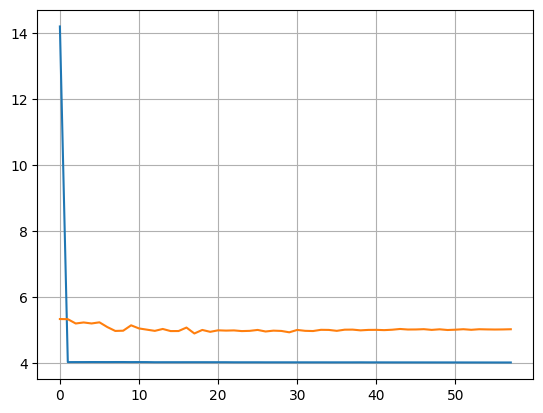

In [7]:
plt.plot(lst_loss_train)
plt.plot(lst_loss_val)
plt.grid()
plt.show()

In [10]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds

model_load = MorseNet(num_classes=num_classes)
model_load.load_state_dict(torch.load('MorseNet.pth'))
model_load.eval()

with torch.no_grad():
    train_mess = []
    train_predicts = []
    for loader in train_dl:
        seq, test_target, _, mess = loader
        train_mess.extend(mess)

        logits = model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        train_predicts.extend(predicted_values)

    val_mess = []
    val_predicts = []
    for loader in val_dl:
        seq, test_target, _, mess = loader
        val_mess.extend(mess)

        logits= model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        val_predicts.extend(predicted_values)

import Levenshtein

mean_acc_test = np.mean([Levenshtein.ratio(test_pred, train_mess[ind]) for ind, test_pred in enumerate(train_predicts)])
mean_acc_val = np.mean([Levenshtein.ratio(val_pred, val_mess[ind]) for ind, val_pred in enumerate(val_predicts)])


print(f"Mean accurasu by The Levenshtein in train is : {mean_acc_test}")
print(f"Mean accurasu by The Levenshtein in validate is : {mean_acc_val}")

CNN размерность выхода: torch.Size([1, 32, 8, 89])
CNN число фичей: 256
Mean accurasu by The Levenshtein in train is : 0.0
Mean accurasu by The Levenshtein in validate is : 0.0


# Сбор sample_submission

In [11]:
def ctc_decoder(logits, int_char_map, blank_label_idx):
    preds = []
    logits_cpu = logits.cpu() 
    max_inds = torch.argmax(logits_cpu.detach(), dim=2).t().numpy() # арзмакс по лагитам и преобразование к словарю
    
    for ind in max_inds:
        merged_inds = []
        for idx in ind:
            if idx != blank_label_idx: 
                merged_inds.append(idx)
        text = "".join([int_char_map.get(i, '?') for i in merged_inds])
        preds.append(text)

    return preds

model_load = MorseNet(num_classes=num_classes)
model_load.load_state_dict(torch.load('MorseNet.pth'))
model_load.eval()

test_ds = MosreDataset(df=sample_data,
                        data_patch=DATASET_PATCH,
                        char_to_int=char_to_int,
                        train=False,
                        transforms=valid_audio_transforms)


test_dl = torch.utils.data.DataLoader(test_ds, batch_size=20, shuffle=False, collate_fn=my_collate)
model_load.eval()

with torch.no_grad():
    test_predicts = []
    for loader in test_dl:
        seq = loader
        logits = model_load(seq)
        predicted_values = ctc_decoder(logits, int_to_char, BLANK_IDX)
        test_predicts.extend(predicted_values)

sample_data.message = test_predicts
sample_data.to_csv('sample_submission.csv', index=False)

CNN размерность выхода: torch.Size([1, 32, 8, 89])
CNN число фичей: 256


In [13]:
test_predicts

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
